# Intel Image Classification

In this notebook we will use convolutional networks to perform single-label multi-class classification. The dataset contains train, test and prediction images for 6 classes ('buildings','forest','glacier','mountain','sea','street').

Let's see the data and decide what model to use.

### Import all the required packages

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import models, layers, optimizers
import matplotlib.image as mpimg
import math

import os

### Set directory paths and initialize parameters

In [2]:
BASE_DIR = '../input/intel-image-classification'
TRAIN_DIR = os.path.join(BASE_DIR, 'seg_train/seg_train')
TEST_DIR = os.path.join(BASE_DIR, 'seg_test/seg_test')
BATCH_SIZE = 20
EPOCHS = 30

#ImageDataGenerator for training data
TRAIN_DATAGEN = ImageDataGenerator(
                rescale = 1.0/255,
                validation_split = 0.2
                )

#ImageDataGenerator for testing data
TEST_DATAGEN = ImageDataGenerator(
                rescale = 1.0/255
                )

Let's see images from each of the classes.

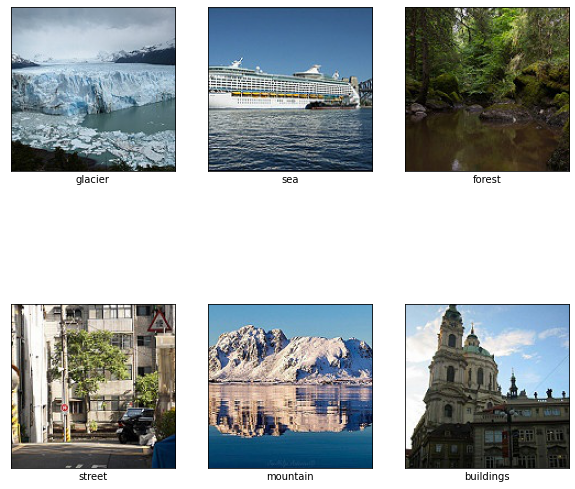

In [3]:
j=0
fig=plt.figure(figsize=(10, 10))
for i in os.listdir(TRAIN_DIR):
        img = mpimg.imread(TRAIN_DIR+"/"+i+"/"+os.listdir(TRAIN_DIR+"/"+i)[0])
        fig.add_subplot(2,3,j+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(i)
        j += 1
plt.show()

In [4]:
print("TRAINING DATA:")
for i in os.listdir(TRAIN_DIR):
    files = os.listdir(TRAIN_DIR+"/"+i)
    print(f'{i} : {len(files)} files')
    
print("\n\nTEST DATA:")
for i in os.listdir(TEST_DIR):
    files = os.listdir(TEST_DIR+"/"+i)
    print(f'{i} : {len(files)} files')

TRAINING DATA:
glacier : 2404 files
sea : 2274 files
forest : 2271 files
street : 2382 files
mountain : 2512 files
buildings : 2191 files


TEST DATA:
glacier : 553 files
sea : 510 files
forest : 474 files
street : 501 files
mountain : 525 files
buildings : 437 files


Almost same number of samples for each class, hence **no class-imbalance** problem.

We have two options to build a model
1. **Convolutional Neural Network from scratch**
2. **Feature Extraction using pretrained networks**

On an average, for every class we have 2300 images in training data, which is less. If we build a convnet from scratch, there are high chances that it will overfit the training data. So option-1 does not seem to be a good one.

Let's see second option.

A pretrained network is a saved network that was previously trained on a large dataset, typically on large-scale image classification task. If the original dataset is large enough and general enough, then the spatial hierarchy of features learned by the network can effectively act as a generic model of the visual world and hence it's features can be useful for many different image classification tasks.

We will use pretrained **VGG16 model**. This model was trained on ImageNet dataset for 1000 classes. Features learned by the initial layers of VGG16 model are generic enough to apply for other image classification tasks.

Let's go with feature extraction using pretrained VGG16 model.


In [5]:
train_generator = TRAIN_DATAGEN.flow_from_directory(
                    TRAIN_DIR,
                    target_size = (150,150),
                    batch_size = BATCH_SIZE,
                    class_mode = 'categorical',
                    subset='training'
                  )

validation_generator = TRAIN_DATAGEN.flow_from_directory(
                    TRAIN_DIR,
                    target_size = (150,150),
                    batch_size = BATCH_SIZE,
                    class_mode = 'categorical',
                    subset='validation'
                  )

test_generator = TEST_DATAGEN.flow_from_directory(
                    TEST_DIR,
                    target_size = (150,150),
                    batch_size = BATCH_SIZE,
                    class_mode = 'categorical'
                  )

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Load the VGG16 model's **convolutional base**.

parameter include_top=False lets us **drop the trained classifier** from VGG16 model.

In [6]:
conv_base = VGG16(
                    weights = 'imagenet',
                    include_top = False,
                    input_shape = (150,150,3)
                 )

58892288/58889256 [==============================] - 0s 0us/step


In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Let's define the model with it's own classifeir on top of VGG16 convolutional base.

In [8]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Nadam(lr=2e-5), metrics=['acc'])

In [10]:
history = model.fit_generator(
                                train_generator,
                                steps_per_epoch = train_generator.samples // BATCH_SIZE,
                                epochs = EPOCHS,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.samples // BATCH_SIZE,
                             )

Epoch 1/30
561/561 [==============================] - 63s 112ms/step - loss: 0.5305 - acc: 0.8095 - val_loss: 0.2697 - val_acc: 0.9100
Epoch 2/30
561/561 [==============================] - 58s 104ms/step - loss: 0.2628 - acc: 0.9099 - val_loss: 0.2513 - val_acc: 0.9175
Epoch 3/30
561/561 [==============================] - 58s 104ms/step - loss: 0.1950 - acc: 0.9326 - val_loss: 0.2524 - val_acc: 0.9175
Epoch 4/30
561/561 [==============================] - 58s 103ms/step - loss: 0.1504 - acc: 0.9503 - val_loss: 0.2229 - val_acc: 0.9271
Epoch 5/30
561/561 [==============================] - 58s 103ms/step - loss: 0.1143 - acc: 0.9615 - val_loss: 0.2406 - val_acc: 0.9261
Epoch 6/30
561/561 [==============================] - 58s 104ms/step - loss: 0.0888 - acc: 0.9695 - val_loss: 0.2791 - val_acc: 0.9036
Epoch 7/30
561/561 [==============================] - 58s 103ms/step - loss: 0.0723 - acc: 0.9754 - val_loss: 0.2638 - val_acc: 0.9207
Epoch 8/30
561/561 [==============================] - 5

In [11]:
def plot_acc_loss(history):

    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc)+1)

    plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'bo', label='Validation accuracy', color='red')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, train_loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'bo', label='Validation loss', color='red')
    plt.title("Training and Validation loss")
    plt.legend()
    plt.show()

    print("Average Validation accuracy: ", np.mean(val_acc))
    print("Average Validation loss: ", np.mean(val_loss))

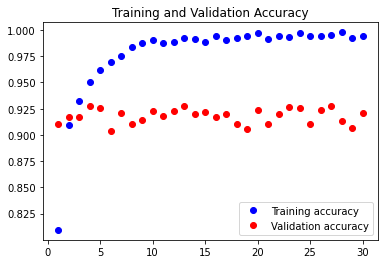

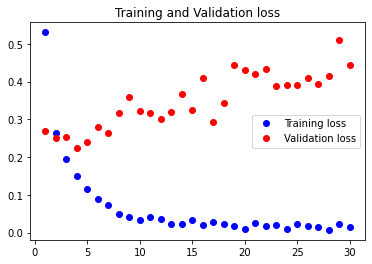

Average Validation accuracy:  0.918071428934733
Average Validation loss:  0.3506775120894114


In [12]:
plot_acc_loss(history)

Let's push the performance a bit further by **fine-tuning** the VGG16 model.

In fine-tuning we slightly adjust the more abstract representations of the model being reused, in order to make them more relevant to the problem at hand. We are going to unfreez last block convolution layers of the model. To limit the magnitude of modification made to pretrained representations, let's keep small learning rate.

In [14]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable = True
    if set_trainable == True:
        layer.trainable = True
    else:
        layer.trainable = False

In [15]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Nadam(lr=1e-5), metrics=['acc'])
history = model.fit_generator(
                                train_generator,
                                steps_per_epoch = train_generator.samples // BATCH_SIZE,
                                epochs = EPOCHS,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.samples // BATCH_SIZE,
                             )

Epoch 1/30
561/561 [==============================] - 29s 51ms/step - loss: 0.0041 - acc: 0.9981 - val_loss: 0.4803 - val_acc: 0.9225
Epoch 2/30
561/561 [==============================] - 28s 50ms/step - loss: 0.0023 - acc: 0.9988 - val_loss: 0.5404 - val_acc: 0.9229
Epoch 3/30
561/561 [==============================] - 29s 51ms/step - loss: 0.0026 - acc: 0.9986 - val_loss: 0.4920 - val_acc: 0.9246
Epoch 4/30
561/561 [==============================] - 28s 50ms/step - loss: 0.0019 - acc: 0.9992 - val_loss: 0.5175 - val_acc: 0.9236
Epoch 5/30
561/561 [==============================] - 29s 51ms/step - loss: 0.0026 - acc: 0.9988 - val_loss: 0.4757 - val_acc: 0.9225
Epoch 6/30
561/561 [==============================] - 28s 50ms/step - loss: 0.0017 - acc: 0.9990 - val_loss: 0.5494 - val_acc: 0.9261
Epoch 7/30
561/561 [==============================] - 29s 51ms/step - loss: 0.0020 - acc: 0.9988 - val_loss: 0.5487 - val_acc: 0.9229
Epoch 8/30
561/561 [==============================] - 28s 50ms

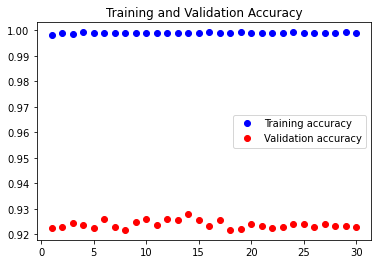

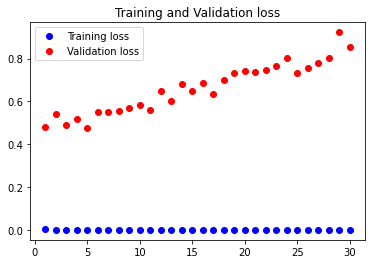

Average Validation accuracy:  0.9238928576310476
Average Validation loss:  0.6614053070545196


In [16]:
plot_acc_loss(history)

Let's apply the model on test data.

In [20]:
test_acc, test_loss = model.evaluate_generator(test_generator, steps=test_generator.samples // BATCH_SIZE)
print("Test Accuracy: ", math.ceil(test_acc*100)/100)

Test Accuracy:  0.9


This approach achieves an accuracy of 90%, Not bad!

From the above plots we see that our model is overfitting the training data, let's address this issue in next version.